In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
selected_classes = [0,1,2,3,5]
num_classes = len(selected_classes)
class_map = {old_label:new_label for new_label, old_label in enumerate(selected_classes)}
full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
indices = []
class_counts = {cls:0 for cls in selected_classes}
for i, (_, label) in enumerate(full_train):
    if label in selected_classes and class_counts[label] < 1000:
        indices.append(i)
        class_counts[label] += 1
    if sum(class_counts.values()) == 5000:
        break

subset_train = Subset(full_train, indices)

In [3]:

augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])
to_tensor = transforms.ToTensor()

In [4]:
class CustomCIFAR10(Dataset):
    def __init__(self, subset, transform=None, augment_times=0):
        self.subset = subset
        self.transform = transform
        self.augment_times = augment_times

    def __len__(self):
        return len(self.subset)*(self.augment_times+1)

    def __getitem__(self, idx):
        base_idx = idx // (self.augment_times+1)
        aug_idx = idx % (self.augment_times+1)
        img, label = self.subset[base_idx]
        if aug_idx > 0 and self.transform:
            img = self.transform(img)  
        elif self.transform:
            img = self.transform(img)  
        label = class_map[label]
        return img, label

train_dataset_raw = CustomCIFAR10(subset_train, transform=to_tensor, augment_times=0)
train_dataset_aug = CustomCIFAR10(subset_train, transform=augmentation_transform, augment_times=2)

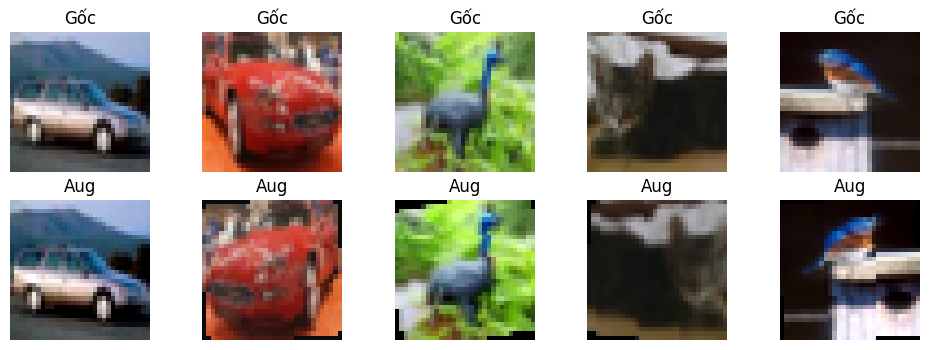

In [5]:
def show_images_raw_vs_aug(original_dataset, augmented_dataset, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        orig_img, _ = original_dataset[i]
        aug_img, _ = augmented_dataset[i*(2+1)+1]
        plt.subplot(2, n, i+1)
        plt.imshow(np.transpose(orig_img.numpy(), (1,2,0)))
        plt.title("Gốc")
        plt.axis('off')
        plt.subplot(2, n, i+n+1)
        plt.imshow(np.transpose(aug_img.numpy(), (1,2,0)))
        plt.title("Aug")
        plt.axis('off')
    plt.show()

show_images_raw_vs_aug(train_dataset_raw, train_dataset_aug, n=5)

In [6]:
train_loader_raw = DataLoader(train_dataset_raw, batch_size=64, shuffle=True)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)

In [7]:
def train_once(model, loader, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    start_time = time.time()
    final_acc = 0
    for epoch in range(epochs):
        correct = 0
        total = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        final_acc = 100.*correct/total
    total_time = time.time() - start_time
    return final_acc, total_time

In [8]:
def evaluate_multiple_runs(loader, runs=3, epochs=5):
    acc_list = []
    time_list = []
    for i in range(runs):
        print(f"Run {i+1}/{runs}...")
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model = model.to(device)
        acc, t = train_once(model, loader, epochs)
        acc_list.append(acc)
        time_list.append(t)
    avg_acc = np.mean(acc_list)
    avg_time = np.mean(time_list)
    return avg_acc, avg_time

In [9]:
print("=== Dữ liệu gốc ===")
avg_acc_raw, avg_time_raw = evaluate_multiple_runs(train_loader_raw, runs=3, epochs=5)
print(f"Trung bình Accuracy: {avg_acc_raw:.2f}%, Trung bình thời gian: {avg_time_raw:.2f}s")

print("\n=== Dữ liệu tăng cường ===")
avg_acc_aug, avg_time_aug = evaluate_multiple_runs(train_loader_aug, runs=3, epochs=5)
print(f"Trung bình Accuracy: {avg_acc_aug:.2f}%, Trung bình thời gian: {avg_time_aug:.2f}s")


=== Dữ liệu gốc ===
Run 1/3...


c:\Users\Hello\anaconda3\envs\dpl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hello\anaconda3\envs\dpl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Run 2/3...
Run 3/3...
Trung bình Accuracy: 73.71%, Trung bình thời gian: 104.14s

=== Dữ liệu tăng cường ===
Run 1/3...
Run 2/3...
Run 3/3...
Trung bình Accuracy: 76.12%, Trung bình thời gian: 596.10s
